In [5]:
from SingleMousePipeline import ModelPipelineSingleMouse
from scipy import io
import sys
sys.path.append("..")
import imp
import EnsemblePursuitModule
import numpy as np
imp.reload(EnsemblePursuitModule)
import time

from EnsemblePursuitModule.EnsemblePursuitNumpyFast import EnsemblePursuitNumpyFast

In [700]:
from sklearn.decomposition import PCA, FastICA, NMF
from scipy.stats import skew

def new_ensemble(X, C, seed_timecourse, lam, discard_first_neuron = False):    
    # X are the NT by NN neural activity traces (z-scored)
    # C is the covariance matrix of X
    # seed_timecourse initializes the ensemble
    # lam is the explained variance threshold
    # discard the first neuron in the ensemble (if this was used to seed the pursuit)
    
    NT, NN = X.shape
    mask_neurons=np.ones((NN,),dtype=bool)
    
    # compute initial bias
    bias = seed_timecourse @ X
    current_v = seed_timecourse
    
    # initialize C_summed
    C_summed = bias.flatten()
    
    # keep track of neuron order
    iorder = np.zeros(NN, 'int32')
    
    n = 0
    while True:
        # at each iteration, first determine the neuron to be added
        imax = np.argmax(C_summed * mask_neurons)
        
        # compute norm of ensemble trace
        vnorm = np.sum(current_v**2)
        
        # compute delta cost function
        cost_delta = np.maximum(0., C_summed[imax])**2 / vnorm
        
        # if cost/variance explained is less than lam (* n_timepoints) then break
        if cost_delta<lam*NT:
            break
            
        # zero out freshly added neuron
        mask_neurons[imax] = False
        
        if n==0 and discard_first_neuron:            
            discard_first_neuron = False
            continue
        
        # add column of C
        C_summed = C_summed + C[:, imax]
        
        # add column of X
        current_v = current_v + X[:, imax]
        
        # keep track of neurons in ensembles
        iorder[n] = imax
        
        n = n+1
    
    # take only first n neurons
    iorder = iorder[:n]
    
    return iorder, current_v

def one_round_of_kmeans(V, X, lam=0.01, threshold=True):
    # V are the NT by nK cluster activity traces
    # X are the NT by NN neural activity traces (z-scored)
    # if the threshold is true, neurons only make it into a cluster if their explained variance is above lam
    # this is useful in the last stages when most neurons only have noise left
    
    NT, nK = V.shape
    
    # computes projections of neurons onto components
    cc = V.T @ X 
    
    # take the biggest projection component for each neuron
    imax = np.argmax(cc, axis=0)
    
    # for every neuron, compute max projection
    w = np.max(cc, axis=0)
    
    # explained variance for each neuron
    amax = np.maximum(0, w)**2/NT
        
    # initialize total explained variance for each cluster
    vm = np.zeros((nK,))
    
    # update each cluster in k-means
    for j in range(nK):
        # take all neurons assigned to this cluster
        ix = imax==j
        if threshold:
            ix = np.logical_and(ix, amax>lam)
        
        # if there are more than 0 neurons assigned
        if np.sum(ix)>0:
            # update the component to be the mean  of assigned neurons
            V[:,j] = X[:, ix] @ w[ix]

            # compute total explained variance for this cluster
            vm[j] = np.sum(amax[ix])
            
    # re-normalize each column of V separately
    V = V/np.sum(V**2 + 1e-6, axis=0)**.5

    return V, vm

def one_round_of_PCA(V, C):    
    # computes projections of neurons onto components
    for t in range(5):
        V = C @ V
        V /= np.sum(V**2)**.5    
        V = V.flatten()

    return V

def initialize_kmeans(X, nK):
    # initialize k-means for matrix X (NT by NN)
    # the columns of X should be Z-SCORED 
    
    # initialize k-means centers. THINK HOW TO MAKE THIS DETERMINISTIC
    t0 = time.time()
    model = PCA(n_components=nK, random_state = 101).fit(X.T)
    V = model.components_.T
    V = V * np.sign(skew(V.T @ X,axis=1))
    print('obtained %d PCs in %2.4f seconds'%(nK, time.time()-t0))

    #np.random.seed(101)
    #rperm = np.random.permutation(X.shape[1])
    #V = X[:, rperm[:nK]]
    #V = np.random.randn(X.shape[0], nK)

    # keep V as unit norm vectors
    V /= np.sum(V**2 + 1e-6, axis=0)**.5

    t0 = time.time()
    
    # 10 iterations is plenty
    for j in range(10):
        # run one round of k-means and update the cluster activities (V)
        V, vm = one_round_of_kmeans(V, X, lam, j>5)

    print('initialized %d clusters with k-means in %2.4f seconds'%(nK, time.time()-t0))

    return V, vm

def ensemble_pursuit(X, lam, nK, nKmeans):
    NT, NN = X.shape

    # convert to float64 for numerical precision
    X = np.float64(X)

    # initialize k-means clusters and compute their variance in vm
    V, vm = initialize_kmeans(X, nKmeans)
    
    # initialize vectors in ensemble pursuit (Vs)
    vs = np.zeros((NT, nK))

    # initialize U 
    U = np.zeros((NN, nK))

    # precompute covariance matrix of neurons
    C = X.T @ X

    # keep track of number of neurons per ensemble
    ns = np.zeros(nK,)

    # time the ensemble pursuit
    t0 = time.time()

    #  outer loop
    for j in range(nK):
        # initialize with "biggest" k-means ensemble (by variance)
        imax = np.argmax(vm)

        # zscore the seed trace
        seed = zscore(V[:, imax])
        
        # fit one ensemble starting from this seed
        iorder, current_v  = new_ensemble(X, C, seed, lam)    

        # keep track of number of neurons
        ns[j] = len(iorder)

        # normalize current_v to unit norm
        current_v /= np.sum(current_v**2)**.5

        # update column of Vs
        vs[:,j] = current_v
        
        # projection of each neuron onto this ensemble trace
        w = current_v @ X

        # update weights for neurons in this ensemble
        U[iorder, j] = w[iorder]

        # update activity trace
        X[:, iorder] -= np.outer(current_v, w[iorder])

        # rank one update to C
        wtw = np.outer(w[iorder],  w)

        # update the columns
        C[:, iorder] -= wtw.T
        
        # update the rows
        C[iorder, :] -= wtw
        
        # add back term for the submatrix of neurons in this ensemble
        C[iorder[:, np.newaxis], iorder] += wtw[:, iorder]

        # run one round of k-means because we changed X
        V, vm = one_round_of_kmeans(V, X, lam)
        
        if j%25==0 or j == nK-1:
            print('ensemble %d, time %2.2f, nr neurons %d, EV %2.4f'%(j, time.time() - t0, len(iorder), 1-np.mean(X**2)))
    print('average sparsity is %2.4f'%(np.mean(U>1e-5)))
    
    return vs, U

# Example of fitting EnsemblePursuit to data

In [763]:
#data_path = 'H:/DATA/downloads/natimg2800_M170604_MP031_2017-06-28.mat'  # this file has red cells (GABA-ergic)
#data_path = 'H:/DATA/downloads/natimg2800_M160825_MP027_2016-12-14.mat' 
#data_path = 'H:/DATA/downloads/natimg2800_M161025_MP030_2017-05-29.mat' 
#data_path='H:/DATA/downloads/natimg2800_M170714_MP032_2017-08-07.mat' # this file has red cells (GABA-ergic)
#data_path = 'H:/DATA/downloads/natimg2800_M170717_MP033_2017-08-20.mat' 
data_path='H:/DATA/downloads/natimg2800_M170717_MP034_2017-09-11.mat' 

X = io.loadmat(data_path)['stim'][0]['resp'][0]

# standardize the columns of X
X = (X - np.mean(X,axis=0)) / (1e-5 + np.std(X, axis=0))

#X = X / (1e-5 + np.mean(X,axis=0)) # this is the right kind of preprocessing for NMF, do not z-score !!!

print('Shape of the data matrix, timepoints by neurons:',X.shape)

Shape of the data matrix, timepoints by neurons: (5880, 10103)


In [764]:
# define lam
lam = .01
# define number of ensembles
nK = 150
nKmeans = 25

vs, W = ensemble_pursuit(X, lam, nK, nKmeans)
# vs are the ensemble traces, W is the sparse matrix of weights for each neuron


obtained 25 PCs in 1.2377 seconds
initialized 25 clusters with k-means in 3.1625 seconds
ensemble 0, time 9.05, nr neurons 7705, EV 0.0196
ensemble 25, time 24.40, nr neurons 315, EV 0.0606
ensemble 50, time 32.59, nr neurons 195, EV 0.0795
ensemble 75, time 38.46, nr neurons 151, EV 0.0924
ensemble 100, time 42.87, nr neurons 98, EV 0.1020
ensemble 125, time 46.50, nr neurons 45, EV 0.1099
ensemble 149, time 49.37, nr neurons 34, EV 0.1162
average sparsity is 0.0231


In [765]:
# two-repeats decoding
import utils

dat   = io.loadmat(data_path)
istim = dat['stim']['istim'][0][0].astype(np.int32) # stimulus information
stat  = dat['stat'] # per-neuron information

istim -= 1 # get out of MATLAB convention
istim  = istim[:,0]
nimg   = istim.max() # these are blank stims (exclude them)

V     = vs 
valid_stims = istim<nimg

V     = V[valid_stims, :]
istim = istim[valid_stims]

x_train,x_test,y_train,y_test=utils.test_train_split(V,istim)

x_train  = zscore(x_train, axis=1) 
x_test   = zscore(x_test, axis=1)
corr_mat = x_train @ x_test.T # if traces are z-scored, correlation is equivalent to covariance

# compute fraction of correct decodings
print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.shape[0],1,int)))

0.43714285714285717


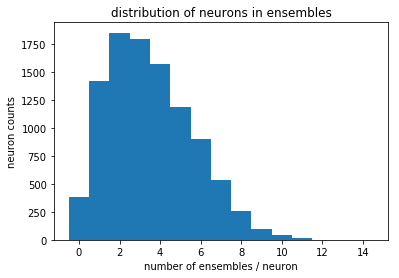

In [759]:
plt.hist(np.sum(W>0, axis=1), bins = np.arange(-.5,15,1))
plt.xlabel('number of ensembles / neuron')
plt.ylabel('neuron counts')
plt.title('distribution of neurons in ensembles')
plt.show()


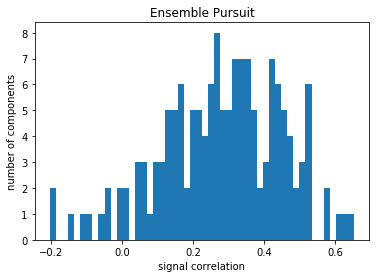

In [760]:
# compute correlation of ensembles between the two repeats
cc = np.mean(x_train * x_test, axis=0)
plt.hist(cc, 50)
plt.xlabel('signal correlation')
plt.ylabel('number of components')
plt.title('Ensemble Pursuit')
plt.show()

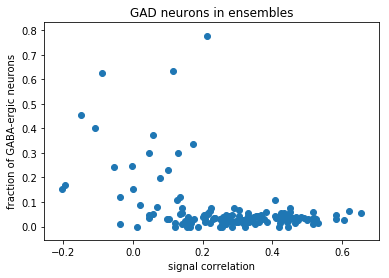

In [761]:
# how are the GAD neurons distributed in ensembles?
red = np.array([stat[n]['redcell'][0][0][0] for n in range(len(stat))]) # extract boolean variable (is this neuron GABA?)

spW = np.sum(W>0, axis=1)
redness = np.array([np.mean(red[W[:,n]>0]) for n in range(W.shape[1])])
plt.scatter(cc, redness)

plt.xlabel('signal correlation')
plt.ylabel('fraction of GABA-ergic neurons')
plt.title('GAD neurons in ensembles')
plt.show()



0.29178571428571426


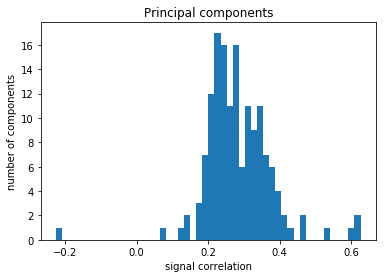

In [762]:
# same as above for PCs

V = PCA(n_components=nK).fit(X.T).components_.T
V     = V[valid_stims, :]
x_train,x_test,y_train,y_test=utils.test_train_split(V,istim)
x_train  = zscore(x_train, axis=1) 
x_test   = zscore(x_test, axis=1)
corr_mat = x_train @ x_test.T # if traces are z-scored, correlation is equivalent to covariance
# compute fraction of correct decodings
print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.shape[0],1,int)))


cc = np.mean(x_train * x_test, axis=0)
plt.hist(cc, 50)
plt.xlabel('signal correlation')
plt.ylabel('number of components')
plt.title('Principal components')
plt.show()



# Figure out how to get behavior for these old datasets
At very least we have spontaneous activity so we can compute variance of ensemble during spontaneous activity

# Extract receptive fields 

In [ ]:
# to do (Maria): add the receptive field estimation to this notebook
# do NOT use classes, so that functions can be called on any array

# Ideas on what to do

You can modify the pipeline to fit other unsupervised models from sklearn for example. There are tons of unsupervised models on sklearn, such as PCA, sparsePCA, Latent Dirichlet Allocation, NMF and so forth. See some of the results from our poster https://github.com/mariakesa/EnsemblePursuit/blob/master/SAND9Poster Feel free to play around with the code and modify it as needed. 